# Step 1: Dataset Selection and Data Preprocessing



In [ ]:
!pip install opencv-python
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
folder_path = '/content/drive/MyDrive/Dataset_A'
print(os.listdir(folder_path))


['Normal', 'Covid']


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler


In [ ]:

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Load dataset
dataset = ImageFolder(root='/content/drive/MyDrive/Dataset_A', transform=data_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [ ]:
len(train_set), len(val_set), len(test_set)

(294, 58, 40)

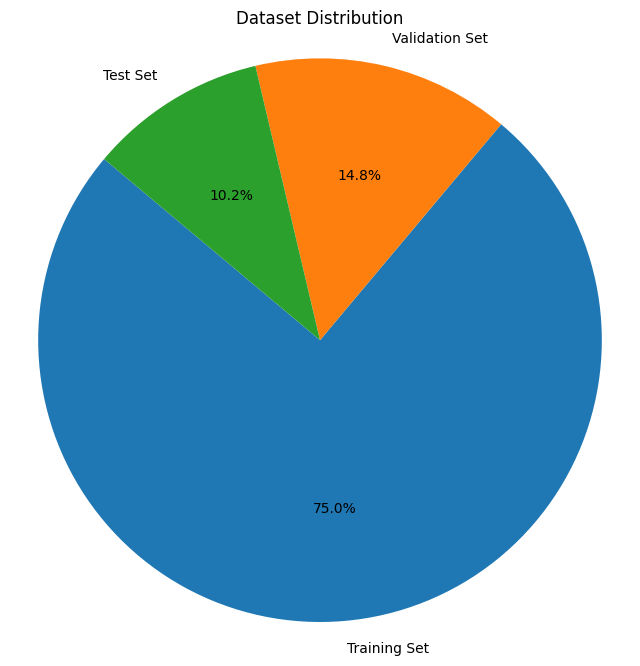

In [ ]:
# Data
dataset_lengths = [len(train_set), len(val_set), len(test_set)]
dataset_labels = ['Training Set', 'Validation Set', 'Test Set']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(dataset_lengths, labels=dataset_labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution')
plt.axis('equal')
plt.show()


Image 1 shape: (1482, 1989, 3)
Image 2 shape: (1632, 1610, 3)


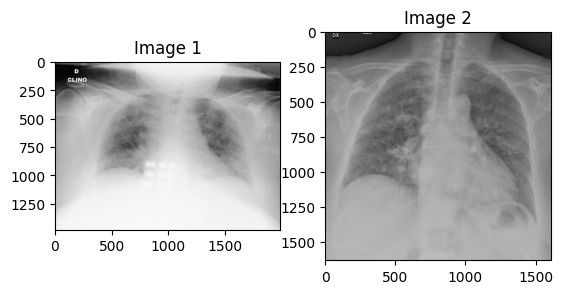

In [ ]:
EXAMPLE_IMG_PATH1 = "/content/drive/MyDrive/Dataset_A/Covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg"
EXAMPLE_IMG_PATH2 = "/content/drive/MyDrive/Dataset_A/Covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg"

img1 = cv2.imread(EXAMPLE_IMG_PATH1)
img2 = cv2.imread(EXAMPLE_IMG_PATH2)

if img1 is not None and img2 is not None:
    print(f"Image 1 shape: {img1.shape}")
    print(f"Image 2 shape: {img2.shape}")

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title("Image 1")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title("Image 2")

    plt.show()
else:
    print("Failed to load one or both of the images. Please check the file paths.")


# Step 2: Model Selection and Architecture



In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# Define the CNN model architecture using Resnet-18
class COVID19Detector(nn.Module):
    def __init__(self):
        super(COVID19Detector, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)  # Output layer with 2 classes (COVID-19 positive or negative)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = COVID19Detector()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Assuming you have already defined the model and other necessary variables

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Step 3: Model Training



In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
train_acc = []
val_losses = []
val_acc = []

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/5], Training Loss: 0.2346, Training Accuracy: 0.9320, Validation Loss: 1.7432, Validation Accuracy: 0.7759
Epoch [2/5], Training Loss: 0.0200, Training Accuracy: 0.9898, Validation Loss: 0.4659, Validation Accuracy: 0.9655
Epoch [3/5], Training Loss: 0.0608, Training Accuracy: 0.9762, Validation Loss: 0.4300, Validation Accuracy: 0.9310
Epoch [4/5], Training Loss: 0.0196, Training Accuracy: 0.9864, Validation Loss: 0.0884, Validation Accuracy: 0.9655
Epoch [5/5], Training Loss: 0.0093, Training Accuracy: 0.9932, Validation Loss: 0.1930, Validation Accuracy: 0.9655


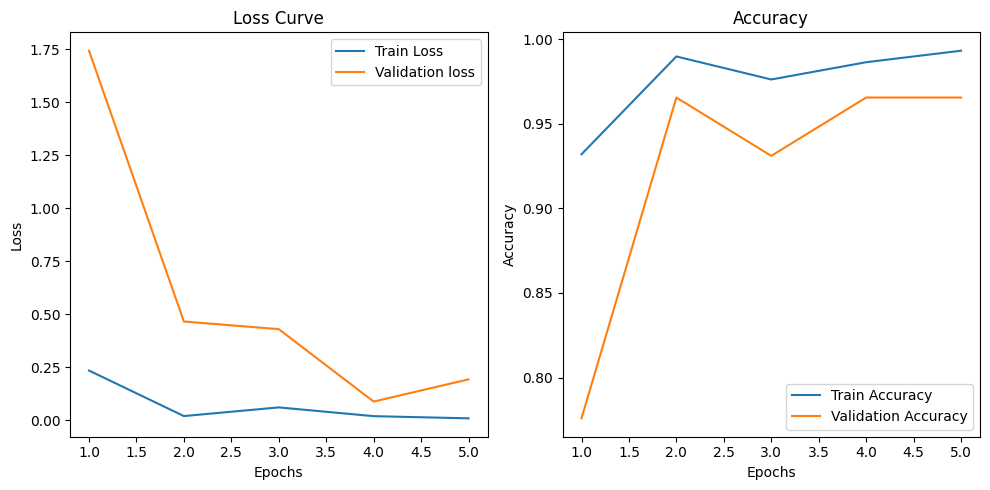

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(range(1, 6), train_losses[:5], label='Train Loss')
axes[0].plot(range(1, 6), val_losses[:5], label='Validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()

axes[1].plot(range(1, 6), train_acc[:5], label='Train Accuracy')
axes[1].plot(range(1, 6), val_acc[:5], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
preds = []
img_list = []
true_labels = []
with torch.no_grad():
  for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      preds.extend(predicted)
      img_list.extend(images.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

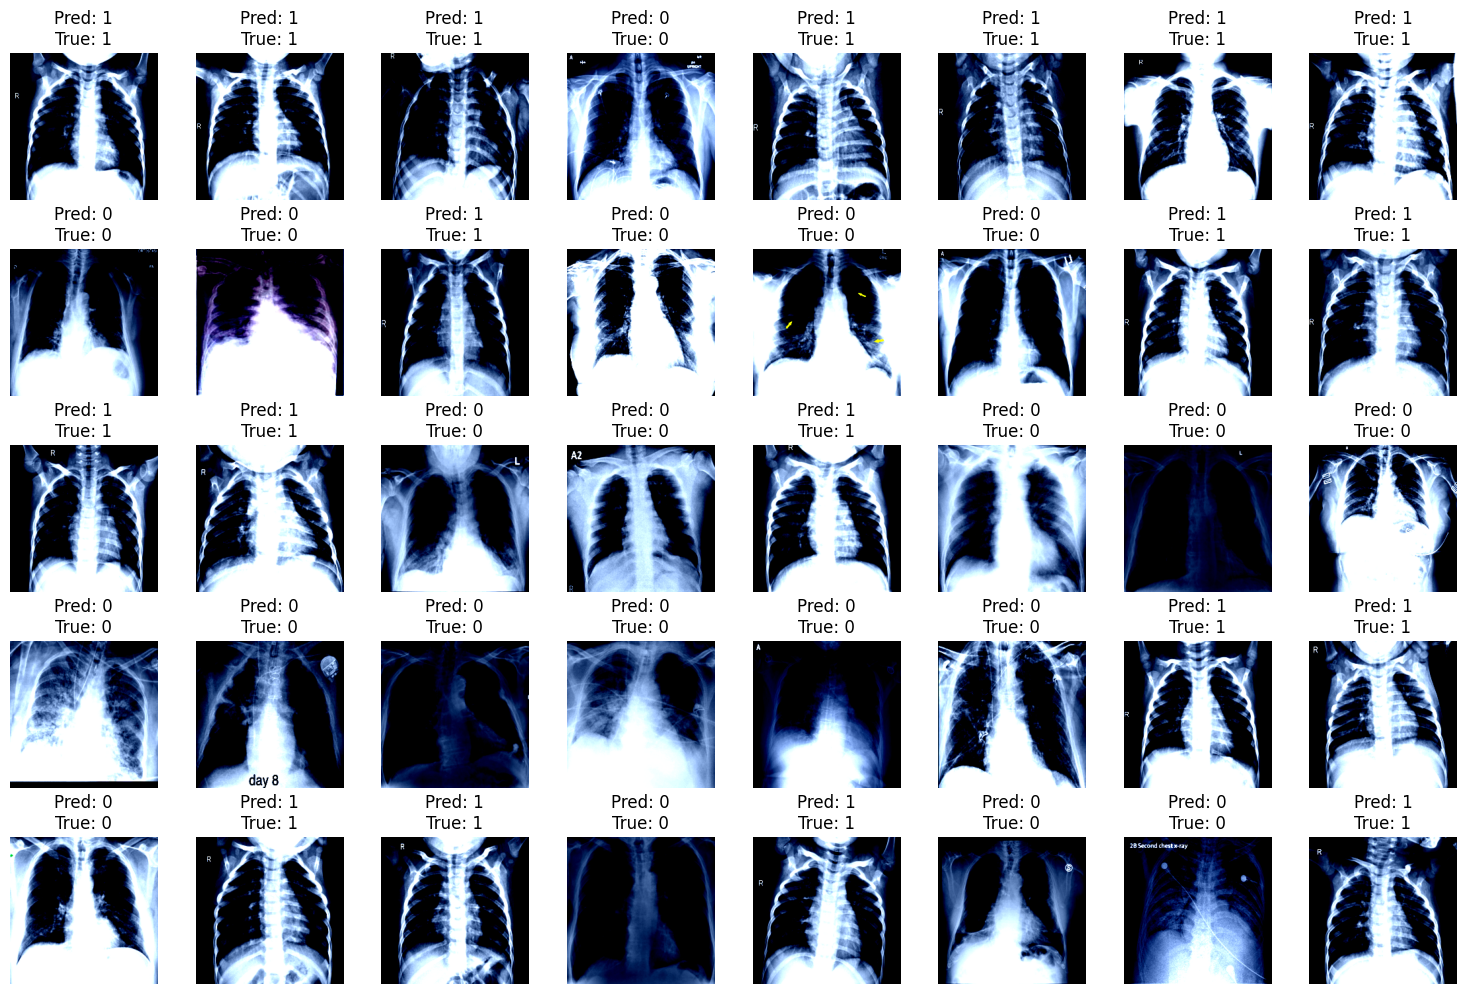

In [ ]:
num_rows = 5
num_cols = 8

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Iterator for test_loader
for i in range(len(preds)):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(np.clip(img_list[i].transpose(1, 2, 0), 0, 1))
    ax.set_title(f"Pred: {preds[i]}\nTrue: {true_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Step 4: Evaluation



Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95        22
       COVID       0.97      0.97      0.97        36

    accuracy                           0.97        58
   macro avg       0.96      0.96      0.96        58
weighted avg       0.97      0.97      0.97        58



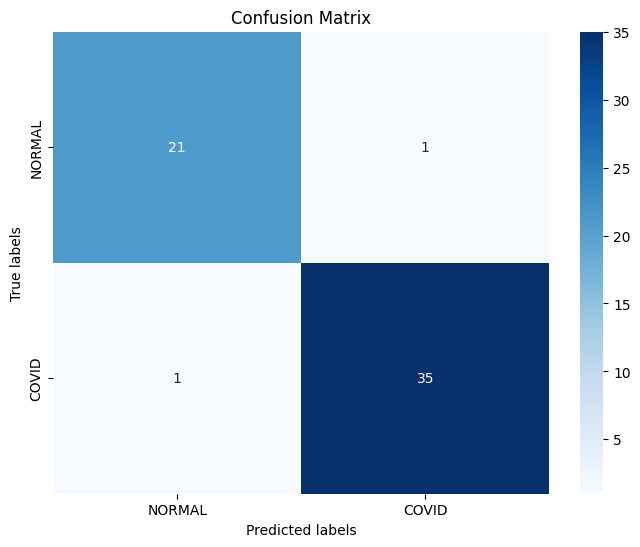

In [ ]:
# Evaluate the model on the validation set
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

class_names = ['NORMAL', 'COVID']
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Step 6: Final Model Testing



In [ ]:
# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 1.0000


In [ ]:
# Lists to store correctly and incorrectly predicted images
correctly_predicted_images = []
incorrectly_predicted_images = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Get the indices of correctly and incorrectly predicted images
        correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        # Append correctly predicted images to the list
        for idx in correct_indices:
            correctly_predicted_images.append((images[idx], labels[idx].item(), predicted[idx].item()))

        # Append incorrectly predicted images to the list
        for idx in incorrect_indices:
            incorrectly_predicted_images.append((images[idx], labels[idx].item(), predicted[idx].item()))




Test Accuracy: 1.0000
Correctly Predicted Images:


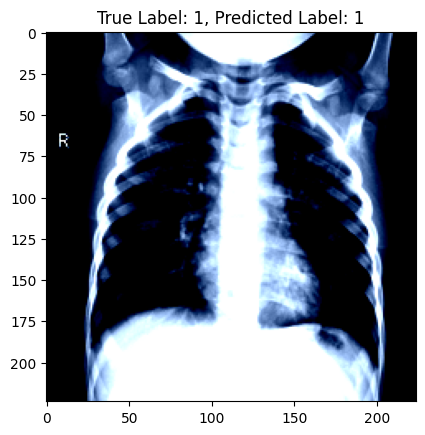

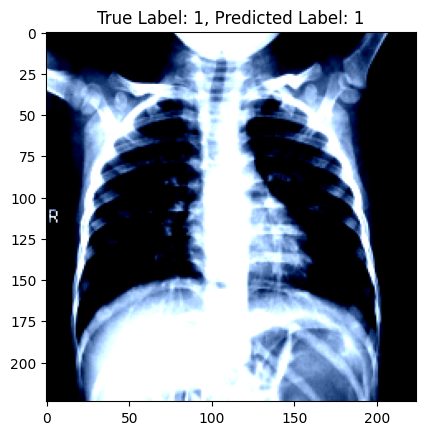

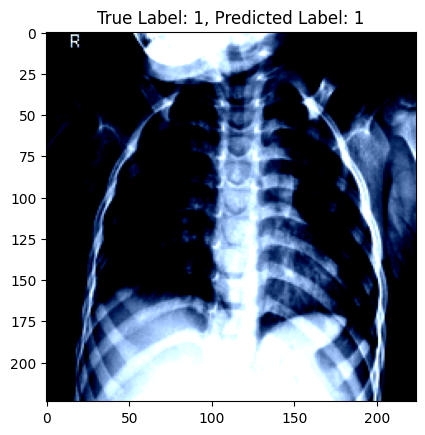

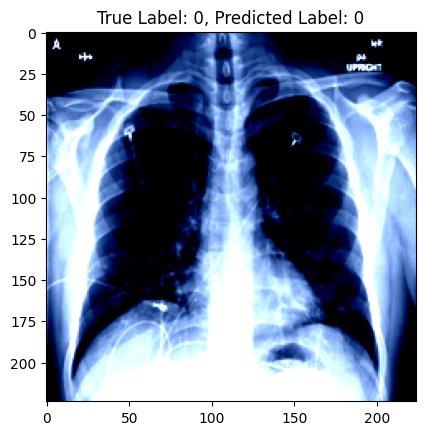

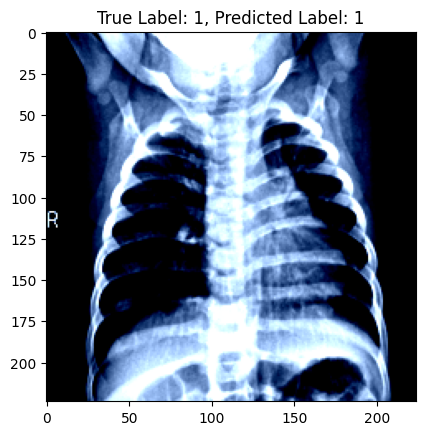

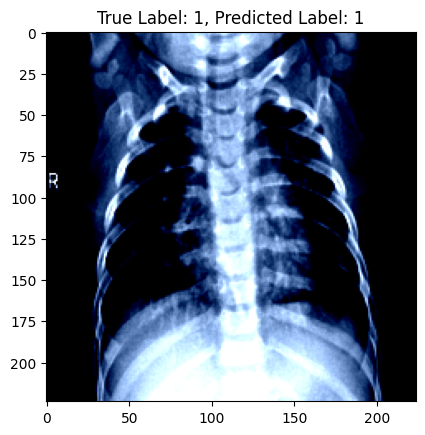

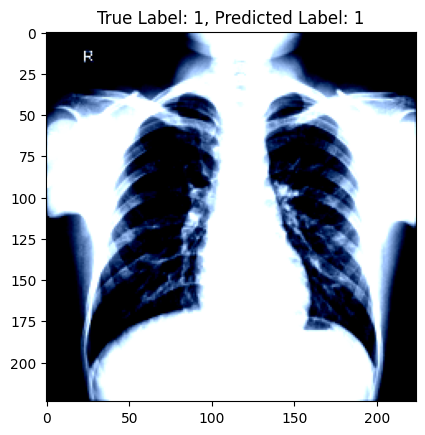

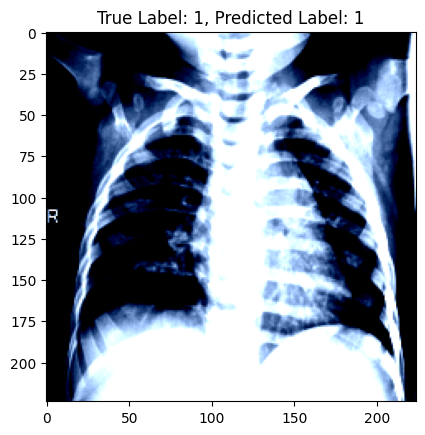

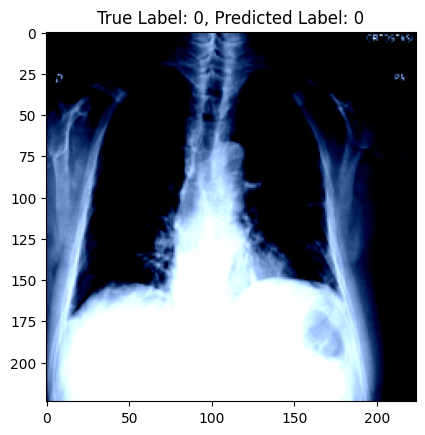

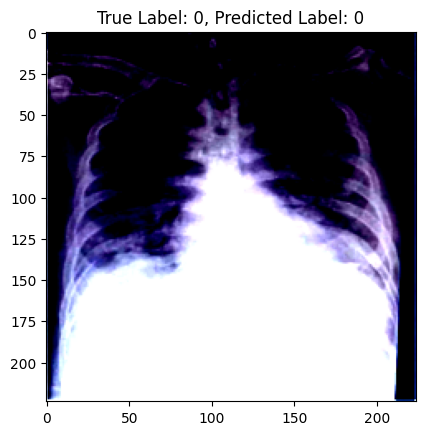

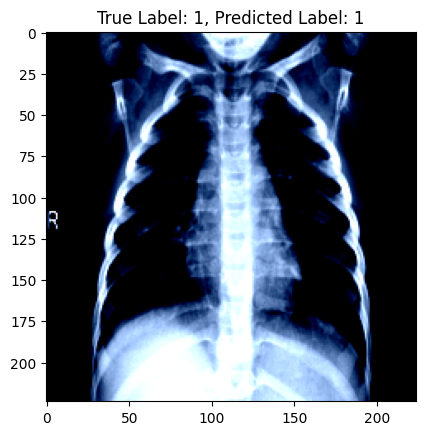

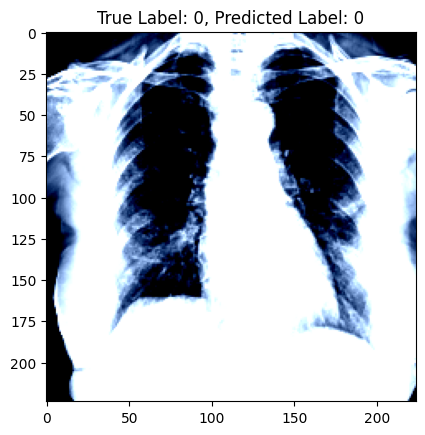

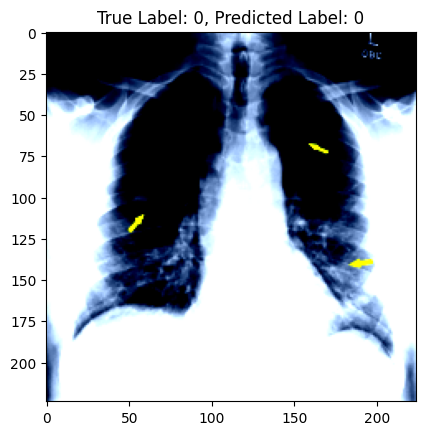

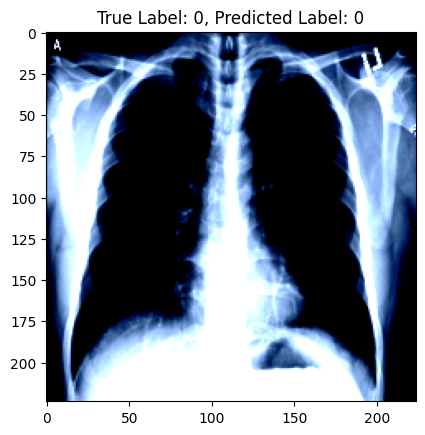

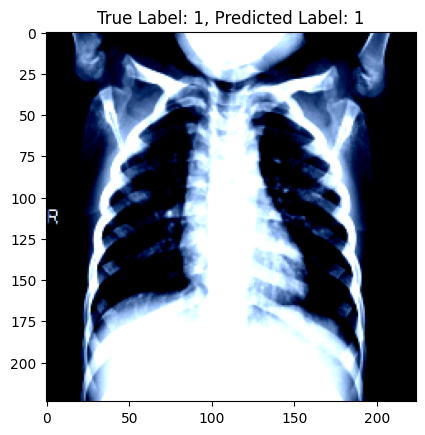

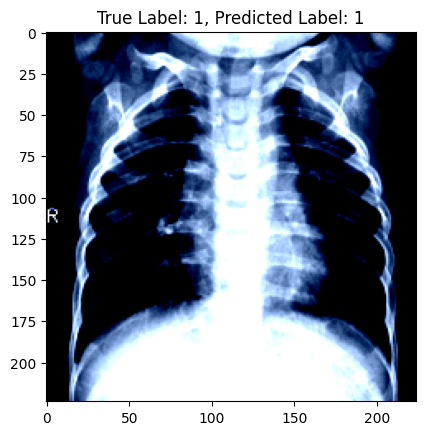

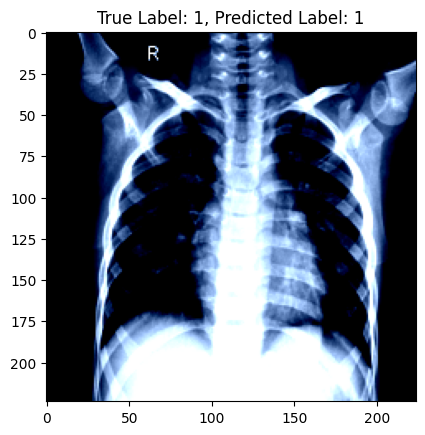

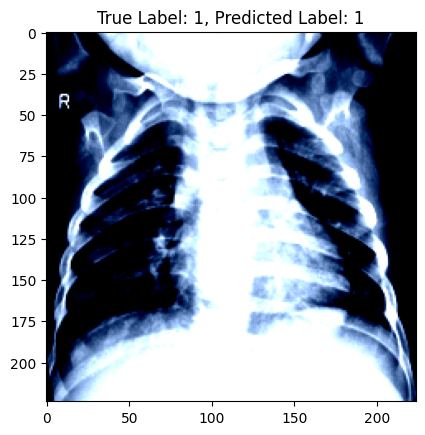

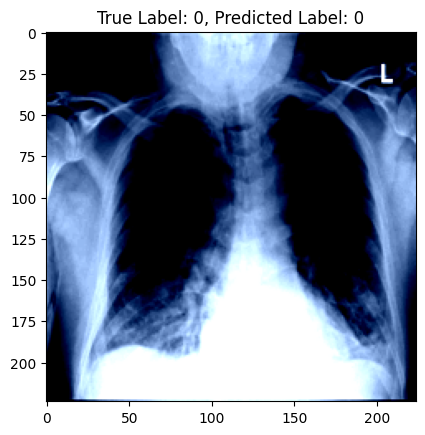

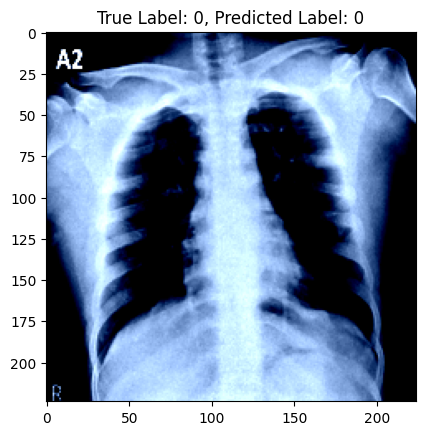

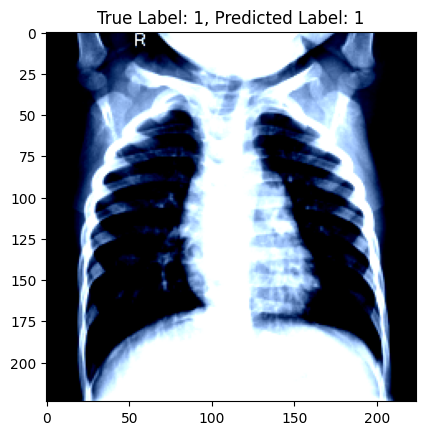

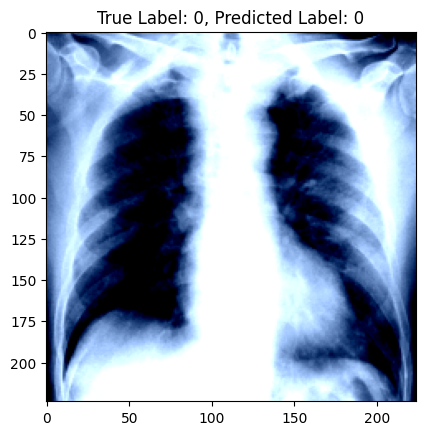

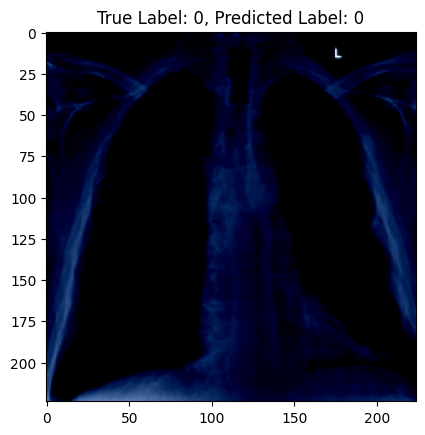

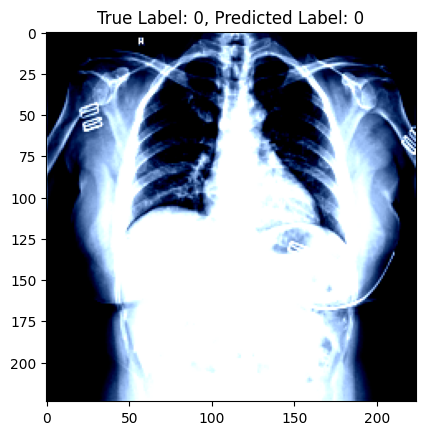

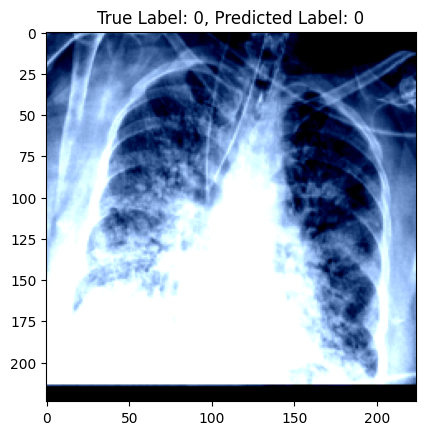

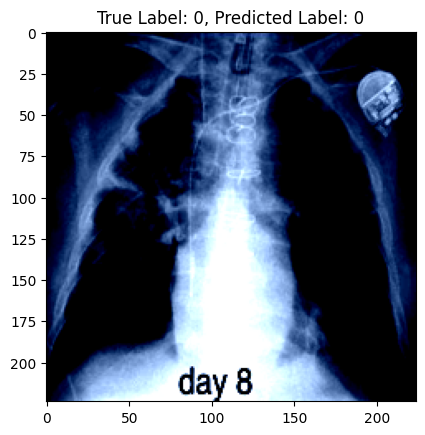

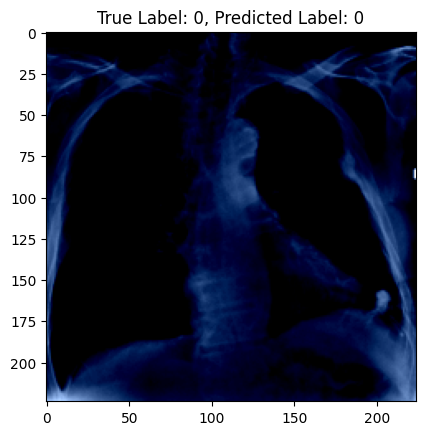

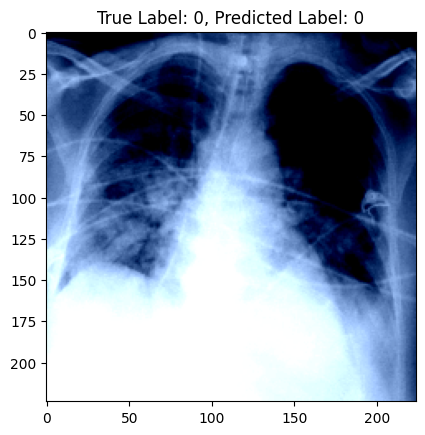

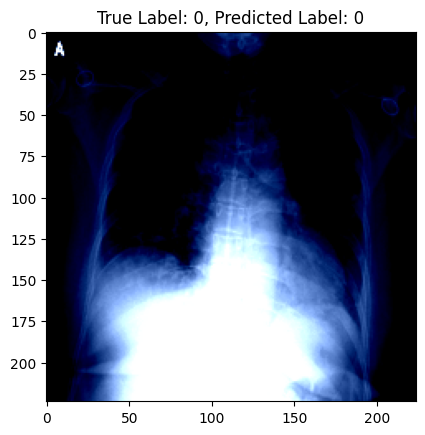

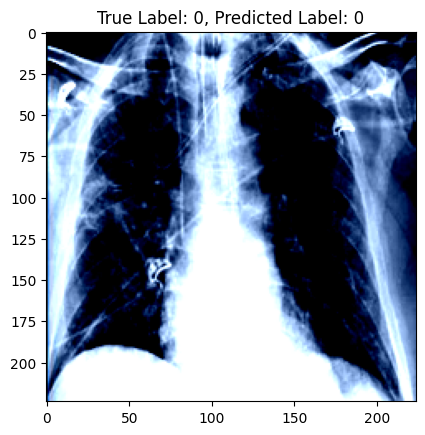

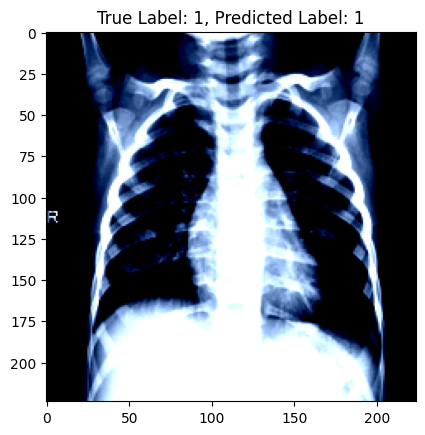

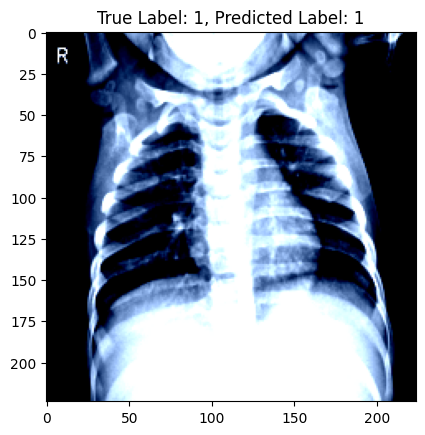

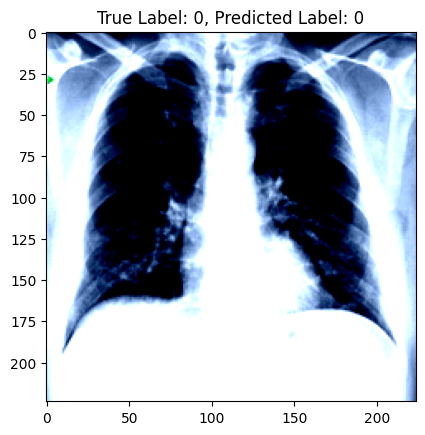

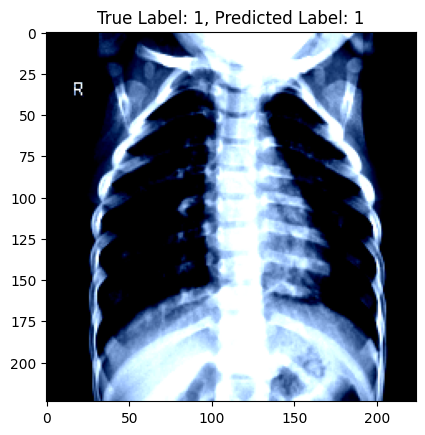

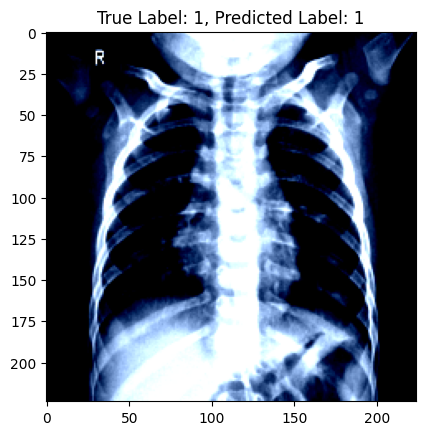

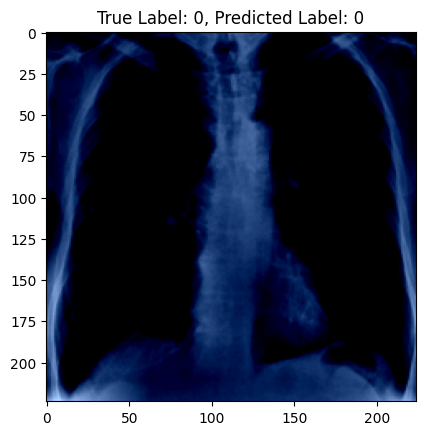

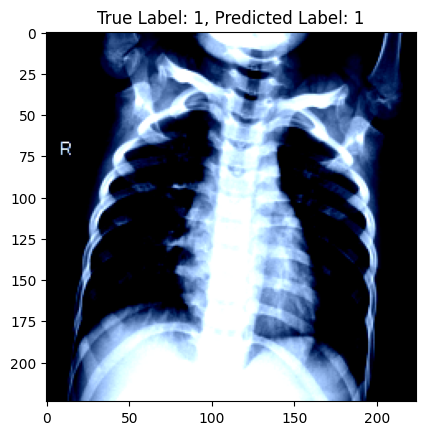

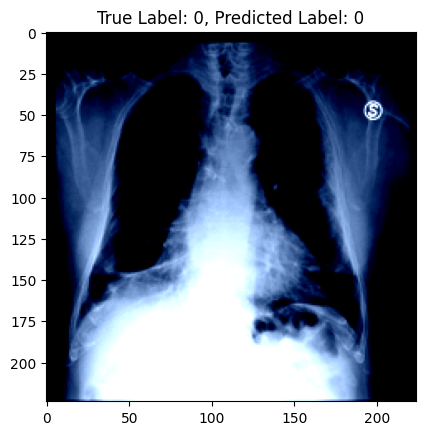

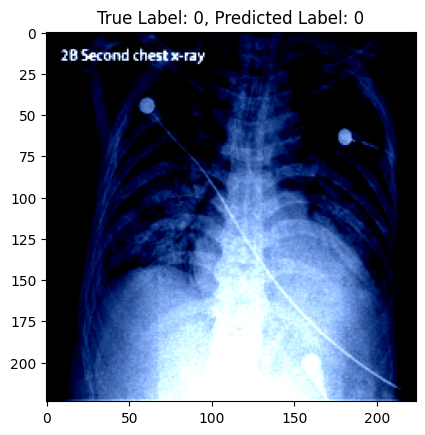

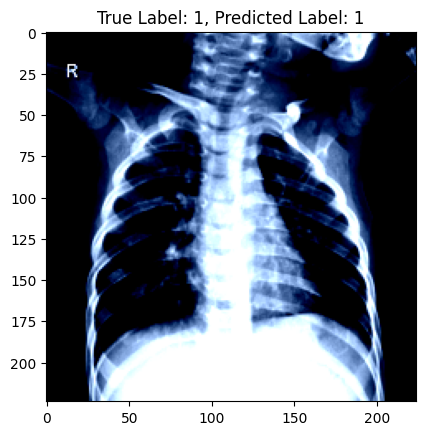

Incorrectly Predicted Images:


In [ ]:
# Calculate test accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display correctly predicted images
print("Correctly Predicted Images:")
for i, (image, true_label, predicted_label) in enumerate(correctly_predicted_images):
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for visualization
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()

# Display incorrectly predicted images
print("Incorrectly Predicted Images:")
for i, (image, true_label, predicted_label) in enumerate(incorrectly_predicted_images):
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for visualization
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()


In [ ]:
# Evaluate the final model on the test set
model.eval()
covid_positive_correct = 0
covid_negative_correct = 0
covid_positive_total = 0
covid_negative_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Separate images into COVID-19 positive and negative
        covid_positive_mask = labels == 1
        covid_negative_mask = labels == 0
        covid_positive_images = images[covid_positive_mask]
        covid_negative_images = images[covid_negative_mask]

        # Predictions for COVID-19 positive images
        covid_positive_predicted = predicted[covid_positive_mask]
        covid_positive_total += covid_positive_images.size(0)
        covid_positive_correct += (covid_positive_predicted == 1).sum().item()

        # Predictions for COVID-19 negative images
        covid_negative_predicted = predicted[covid_negative_mask]
        covid_negative_total += covid_negative_images.size(0)
        covid_negative_correct += (covid_negative_predicted == 0).sum().item()

# Calculate accuracy for COVID-19 positive and negative images
covid_positive_accuracy = covid_positive_correct / covid_positive_total
covid_negative_accuracy = covid_negative_correct / covid_negative_total

print(f"COVID-19 Positive Image Accuracy: {covid_positive_accuracy:.4f}")
print(f"COVID-19 Negative Image Accuracy: {covid_negative_accuracy:.4f}")


COVID-19 Positive Image Accuracy: 1.0000
COVID-19 Negative Image Accuracy: 1.0000
